In [1]:
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook

# Torch, Sklearn imports
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, Dataset, DataLoader, RandomSampler
print(torch.__version__)

## Embeddings
from gensim.models import KeyedVectors

## NLP libs
from nltk import download
import gensim

stopwords = {"ourselves", "hers", "between", "yourself", "but", "again", "there", "about", "once", "during", "out", "very", "having", "with", "they", "own", "an", "be", "some", "for", "do", "its", "yours", "such", "into", "of", "most", "itself", "other", "off", "is", "s", "am", "or", "who", "as", "from", "him", "each", "the", "themselves", "until", "below", "are", "we", "these", "your", "his", "through", "don", "nor", "me", "were", "her", "more", "himself", "this", "down", "should", "our", "their", "while", "above", "both", "up", "to", "ours", "had", "she", "all", "no", "when", "at", "any", "before", "them", "same", "and", "been", "have", "in", "will", "on", "does", "yourselves", "then", "that", "because", "what", "over", "why", "so", "can", "did", "not", "now", "under", "he", "you", "herself", "has", "just", "where", "too", "only", "myself", "which", "those", "i", "after", "few", "whom", "t", "being", "if", "theirs", "my", "against", "a", "by", "doing", "it", "how", "further", "was", "here", "than"}

1.2.0


In [2]:
# !git clone https://github.com/cybertronai/pytorch-sso.git
# %cd pytorch-sso
# !python setup.py install;
# %cd ..

In [3]:
import torch
import torchsso
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import argparse
import inspect

import imageio
import pickle

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchsso

from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None, act_func="relu"):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        if output_size is not None:
            self.output_size = output_size
            self.squeeze_output = False
        else:
            self.output_size = 1
            self.squeeze_output = True

        # Set activation function
        if act_func == "relu":
            self.act = F.relu
        elif act_func == "tanh":
            self.act = F.tanh
        elif act_func == "sigmoid":
            self.act = torch.sigmoid
        else:
            raise ValueError(f'Invalid activation function: {act_func}')

        # Define layers
        if hidden_sizes is None:
            # Linear model
            self.hidden_layers = []
            self.output_layer = nn.Linear(self.input_size, self.output_size)
        else:
            # Neural network
            features = zip([self.input_size] + hidden_sizes[:-1], hidden_sizes)
            self.hidden_layers = nn.ModuleList([nn.Linear(in_features, out_features) for in_features, out_features in features])
            self.output_layer = nn.Linear(hidden_sizes[-1], self.output_size)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        h = x
        for layer in self.hidden_layers:
            h = self.act(layer(h))

        out = self.output_layer(h)
        if self.squeeze_output:
            out = torch.squeeze(out).view([-1])

        return out

In [6]:
def get_entropy(prob: torch.Tensor):
    entropy = - prob * torch.log(prob) - (1 - prob) * torch.log(1 - prob)
    entropy[entropy != entropy] = 0  # nan to zero
    entropy = entropy.detach().cpu().numpy()
    return entropy

In [7]:
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
device

device(type='cuda')

In [8]:
# Args
n_samples = 100
centers = 5
random_state = 5
batch_size = 20
epochs = 5
plot_interval = 50
n_samples_for_mcplot = 20
fig_dir = 'tmp'
keep_figures = False
out = 'boundary.gif'

In [9]:
#!mkdir tmp

In [10]:
!ls -lah

total 34M
drwxrwxr-x  6 roberto roberto 4.0K Jan 17 14:06 .
drwxrwxr-x 11 roberto roberto 4.0K Sep  1 17:35 ..
-rw-rw-r--  1 roberto roberto  37K Dec 16 14:11 1.text_classifier_roberta_datsaset_resampler.ipynb
-rw-rw-r--  1 roberto roberto  30K Oct 26 11:28 1.text_classifier_roberta.ipynb
-rw-rw-r--  1 roberto roberto  60K Dec 16 14:11 1.text_classifier_roberta_NEW.ipynb
drwxrwxr-x  9 roberto roberto 4.0K Sep  1 17:35 2017-06-custom-intent-engines
-rw-rw-r--  1 roberto roberto  24K Dec 16 14:11 2.uncertainty_swag.ipynb
-rw-rw-r--  1 roberto roberto  28K Oct 25 22:21 3.causality_review.ipynb
-rw-rw-r--  1 roberto roberto 113K Oct 25 22:21 4.dpp_diversity_phrases.ipynb
-rw-rw-r--  1 roberto roberto 157K Oct 25 22:21 4.dpp_image.ipynb
-rw-rw-r--  1 roberto roberto  20K Oct 25 22:21 4.nips2019_papers.ipynb
-rw-rw-r--  1 roberto roberto 1.3M Oct 25 22:21 4.nips2019_papers_simple_altair.ipynb
-rw-rw-r--  1 roberto roberto 230K Oct 25 22:21 4.sample_dpp.ipynb
-rw-rw-r--  1 roberto roberto  18

In [11]:
X, y = make_blobs(n_samples=n_samples, n_features=2, centers=centers, random_state=random_state)
y[y < int(centers) / 2] = 0
y[y >= int(centers) / 2] = 1

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
h = 0.05

In [12]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
data_meshgrid = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float).to(device)

In [13]:
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [14]:
# Model arguments
model_kwargs = dict(input_size=2, output_size=None, hidden_sizes=[128])

model1 = MLP(**model_kwargs)
model1 = model1.to(device)
optimizer1 = torch.optim.Adam(model1.parameters())

model2 = pickle.loads(pickle.dumps(model1))  # create a clone
model2 = model2.to(device)
optimizer2 = torchsso.optim.VOGN(model2, dataset_size=len(train_loader.dataset))

In [15]:
figpaths = []
i = 0  # iteration

50
HERE


RuntimeError: CUDA out of memory. Tried to allocate 78.00 MiB (GPU 0; 10.91 GiB total capacity; 9.93 GiB already allocated; 62.31 MiB free; 272.85 MiB cached)

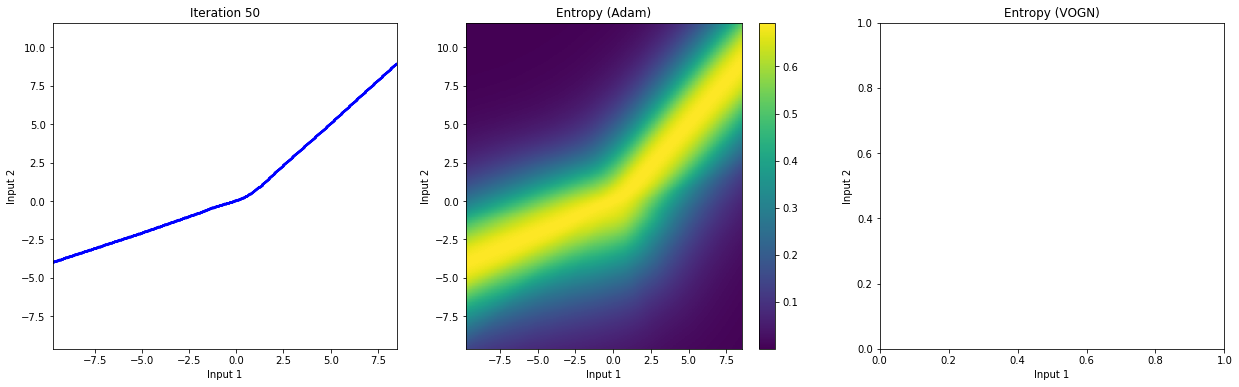

In [18]:
# Run training
for epoch in range(epochs):

    model1.train()
    model2.train()

    for data, target in train_loader:

        data, target = data.to(device), target.to(device)

        def closure1():
            optimizer1.zero_grad()
            output = model1(data)
            loss = F.binary_cross_entropy_with_logits(output, target)
            loss.backward()
            return loss

        def closure2():
            optimizer2.zero_grad()
            output = model2(data)
            loss = F.binary_cross_entropy_with_logits(output, target)
            loss.backward()
            return loss, output

        loss1 = optimizer1.step(closure1)
        loss2, _ = optimizer2.step(closure2)
        print(i+1)
        if (i + 1) % plot_interval == 0:
            print("HERE")
            # Setup figures
            fig = plt.figure(figsize=(21, 6))
            gs = fig.add_gridspec(1, 3)

            # Decision boundary
            ax1 = fig.add_subplot(gs[0, 0])
            ax1.set_xlabel('Input 1')
            ax1.set_ylabel('Input 2')
            ax1.set_title(f'Iteration {i+1}')

            # Entropy (Adam)
            ax2 = fig.add_subplot(gs[0, 1])
            ax2.set_xlabel('Input 1')
            ax2.set_ylabel('Input 2')
            ax2.set_title(f'Entropy (Adam)')

            # Entropy (VOGN)
            ax3 = fig.add_subplot(gs[0, 2])
            ax3.set_xlabel('Input 1')
            ax3.set_ylabel('Input 2')
            ax3.set_title(f'Entropy (VOGN)')

            model1.eval()
            model2.eval()

            # (Adam)
            prob = torch.sigmoid(model1(data_meshgrid)).view(xx.shape)
            entropy = get_entropy(prob)
            pred = torch.round(prob).detach().cpu().numpy()

            plot = ax1.contour(xx, yy, pred, colors=['blue'], linewidths=[2])
            plot.collections[len(plot.collections)//2].set_label('Adam')
            im = ax2.pcolormesh(xx, yy, entropy)
            fig.colorbar(im, ax=ax2)

            # (VOGN) get MC samples
            prob, probs = optimizer2.prediction(data_meshgrid, keep_probs=True)
            print(prob)
            print(probs)
            prob = prob.view(xx.shape)
            entropy = get_entropy(prob)

            probs = probs[:n_samples_for_mcplot]
            preds = [torch.round(p).detach().cpu().numpy().reshape(xx.shape) for p in probs]
            for pred in preds:
                ax1.contour(xx, yy, pred, colors=['red'], alpha=0.01)
            im = ax3.pcolormesh(xx, yy, entropy)
            fig.colorbar(im, ax=ax3)

            # (VOGN) get mean prediction
            prob = optimizer2.prediction(data_meshgrid, mc=0).view(xx.shape)
            pred = torch.round(prob).detach().cpu().numpy()

            plot = ax1.contour(xx, yy, pred, colors=['red'], linewidths=[2])
            plot.collections[len(plot.collections)//2].set_label('VOGN')

            # plot samples
            for label, marker, color in zip([0, 1], ['o', 's'], ['white', 'gray']):
                _X = X[y == label]
                ax1.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors='black', marker=marker)
                ax2.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors='black', marker=marker)
                ax3.scatter(_X[:, 0], _X[:, 1], s=80, c=color, edgecolors='black', marker=marker)

            # save tmp figure
            ax1.grid(linestyle='--')
            ax2.grid(linestyle='--')
            ax3.grid(linestyle='--')
            ax1.set_yticks([-5, 0, 5, 10])
            ax2.set_yticks([-5, 0, 5, 10])
            ax3.set_yticks([-5, 0, 5, 10])
            ax1.legend(loc='lower right')
            ax1.set_aspect(0.8)
            plt.tight_layout()
            figname = f'iteration{i+1}.png'
            figpath = os.path.join(fig_dir, figname)
            if not os.path.isdir(fig_dir):
                os.makedirs(fig_dir)
            fig.savefig(figpath)
            plt.close(fig)
            figpaths.append(figpath)

        i += 1

    print(f'Train Epoch: {epoch+1}\tLoss(Adam): {loss1:.6f} Loss(VOGN): {loss2:.6f}')
    print(f'Train Epoch: {epoch+1}\tLoss(VOGN): {loss2:.6f}')

In [ ]:
!ls -lah tmp

In [ ]:
# Create GIF from temp figures
images = []
for figpath in figpaths:
    images.append(imageio.imread(figpath))
    if not args.keep_figures:
        os.remove(figpath)
imageio.mimsave(out, images, fps=1)